In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["DYLD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"
os.environ["LD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import guillot_transmission
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval, RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from matplotlib.patches import Rectangle
from petitRADTRANS.plotlib import plot_radtrans_opacities

from petitRADTRANS.retrieval.models import (
    isothermal_transmission,
    guillot_transmission,
    guillot_patchy_transmission,
    madhu_seager_patchy_transmission
)
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

# set_petitradtrans_plot_style()
%matplotlib inline

In [2]:
planet = Planet.get("K2-18 b")
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../petit"))

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_guillot_non_grey_clouds_simplified_gamma",
                                run_mode="retrieve",
                                amr=False,
                                scattering_in_emission=True,
                                pressures=np.logspace(-6, 2, 120),
                                  )

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_parameter('D_pl', False, value=124.265*cst.light_year)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = 0.211*cst.r_jup)
retrieval_config.add_parameter('mass', False, value = 0.02807*cst.m_jup)

retrieval_config.add_parameter('T_int', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('T_equ', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('gamma', True, transform_prior_cube_coordinate = lambda x : log_prior(x, -1, 1))
retrieval_config.add_parameter('log_kappa_IR', True, transform_prior_cube_coordinate = lambda x : -3+4.5*x)
retrieval_config.add_parameter('fsed_H2O(l)', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -3, 1))
retrieval_config.add_parameter('log_kzz', True, transform_prior_cube_coordinate = lambda x: 4+8*x)
retrieval_config.add_parameter('log_X_cb_H2O(l)', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('sigma_lnorm', True, transform_prior_cube_coordinate = lambda x: 1.05+1.95*x)
retrieval_config.add_parameter('log_Pbase_H2O(l)',  True, transform_prior_cube_coordinate = lambda x: -5+5*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.set_line_species(['CH4', 'CO2'], eq=False, abund_lim = (-8.0,-0.1))
retrieval_config.add_cloud_species('H2O(l)', eq=True)

retrieval_config.parameters['T_int'].plot_in_corner = True
retrieval_config.parameters['T_int'].corner_ranges = (0,600)
retrieval_config.parameters['T_equ'].plot_in_corner = True
retrieval_config.parameters['T_equ'].corner_ranges = (0,600)
# retrieval_config.parameters['gamma'].plot_in_corner = True
# retrieval_config.parameters['gamma'].corner_transform = lambda x: np.log10(x)
# retrieval_config.parameters['gamma'].corner_ranges = (-2,1)
# retrieval_config.parameters['log_kappa_IR'].plot_in_corner = True
# retrieval_config.parameters['log_kappa_IR'].corner_ranges = (-3,1)
# retrieval_config.parameters['log_X_cb_H2O(l)'].plot_in_corner = True
# retrieval_config.parameters['log_X_cb_H2O(l)'].corner_ranges = (-6,0)
# retrieval_config.parameters['sigma_lnorm'].plot_in_corner = True
# retrieval_config.parameters['sigma_lnorm'].corner_ranges = (1.05,3)
# retrieval_config.parameters['log_Pbase_H2O(l)'].plot_in_corner = True
# retrieval_config.parameters['log_Pbase_H2O(l)'].corner_ranges = (-5,0)
# retrieval_config.parameters['patchiness'].plot_in_corner = True
# retrieval_config.parameters['patchiness'].corner_ranges = (0,1)

for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

output_directory = os.path.join(root_path, "outputs")
retrieval = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      use_mpi = False,        # Run locally, don't need to use MPI for massive parallelisation
                      evaluate_sample_spectra=False,      # Output the spectrum from nsample random samples.
                      use_prt_plot_style=True,
                      ultranest=False)        # Let's use pyMultiNestopacities = plot_radtrans_opacities(

retrieval.run(n_live_points=100,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=False,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbun

In [3]:
## Getting samples
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]

## Getting the best-fit model
log_l, best_fit_index = retrieval.get_best_fit_likelihood(samples_use)
sample_use = samples_use[:-1, best_fit_index]

best_fit_wavelengths, best_fit_spectrum, contribution = retrieval.get_best_fit_model(
                sample_use,
                parameters_read,
                model_generating_function=guillot_transmission,
                contribution=True
            )

Best fit likelihood = 28841.37
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.c

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_36510/3108349087.py:36: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'Best fit spectra, $\chi_v^2$={chi2:.2f}', pad = 20, fontsize=22)


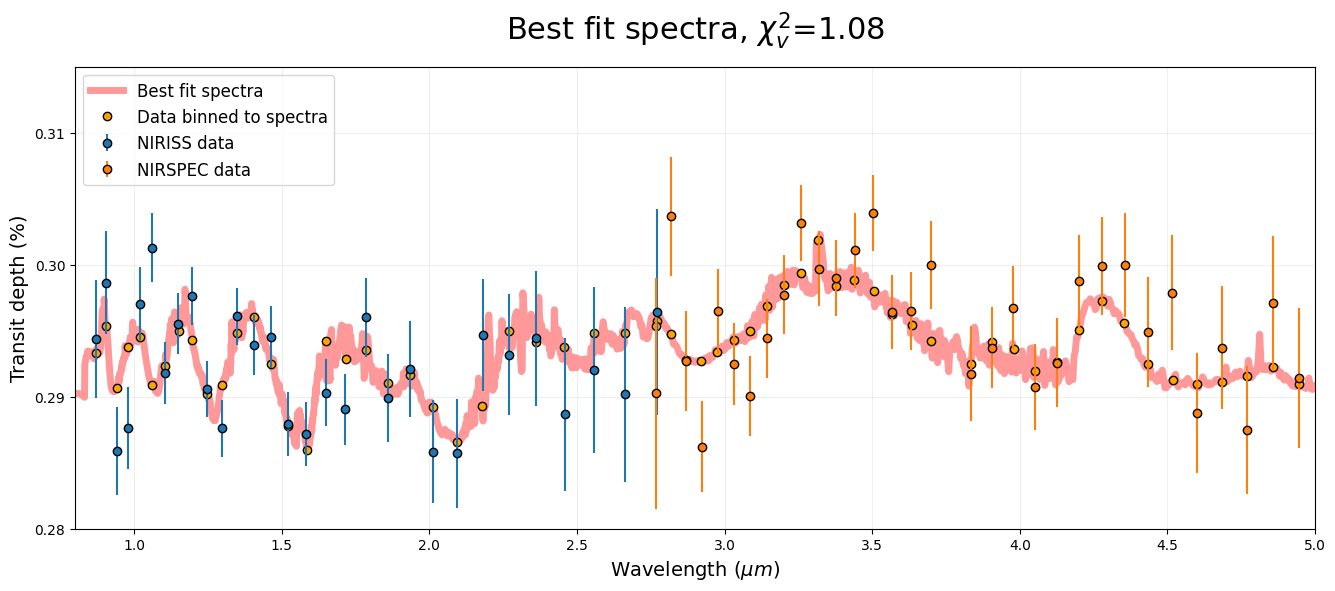

In [4]:
## Loading the low resolution spectra
niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), 
                 skiprows=1, names=["wl", "td", "td_e"], sep=r"\s", engine='python')
nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), 
                  skiprows=1, names=["wl", "td", "td_e"], sep=r"\s", engine='python')

## Binning the best fit model to spectra data
idx_niriss = []
idx_nirspec = []
for i in range(niriss["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-niriss["wl"][i])**2)
    idx_niriss.append(minIndex)

for j in range(nirspec["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-nirspec["wl"][j])**2)
    idx_nirspec.append(minIndex)

## Calculating the reduced chi squared
chi2 = retrieval.get_reduced_chi2_from_model(best_fit_wavelengths, best_fit_spectrum, subtract_n_parameters = True)

## Plot of the best-fit spectra
ax = plt.figure(figsize=(16,6)).gca()
ax.plot(best_fit_wavelengths, best_fit_spectrum*100, 
    color="red", alpha=0.4, linewidth=5, zorder=1, label="Best fit spectra")
ax.plot(best_fit_wavelengths[idx_niriss], best_fit_spectrum[idx_niriss]*100, 'o',
      color="orange", markeredgecolor="k", zorder=2, label="Data binned to spectra")
ax.plot(best_fit_wavelengths[idx_nirspec], best_fit_spectrum[idx_nirspec]*100, 'o',
      color="orange", markeredgecolor="k", zorder=2)
ax.errorbar(niriss["wl"], niriss["td"]*100, yerr = niriss["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRISS data", zorder=3)
ax.errorbar(nirspec["wl"], nirspec["td"]*100, yerr = nirspec["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRSPEC data", zorder=3)
ax.set(xlim=(0.8, 5),
   xticks=np.arange(1, 5.5, 0.5), 
   ylim=(0.28, 0.315),
   yticks=[0.28, 0.29, 0.30, 0.31],
  )
ax.set_title(f'Best fit spectra, $\chi_v^2$={chi2:.2f}', pad = 20, fontsize=22)
ax.set_ylabel('Transit depth (%)', fontsize=14)
ax.set_xlabel(r'Wavelength (${\mu m}$)', fontsize=14)
ax.grid(alpha=0.2)
ax.legend(loc="upper left", fontsize=12)
plt.show()

pressure_scaling 1
pressure_width 1
pressure_simple 120
D_pl 1.1756376721752531e+20
stellar_radius 30610800000.0
planet_radius 1508481200.0
mass 5.328035744722294e+28
T_int 284.0026239819404
T_equ 96.09988810568775
gamma 8.383931038123258
log_kappa_IR -2.063110858589522
fsed_H2O(l) 0.09932985297624257
log_kzz 9.117726320258017
log_X_cb_H2O(l) -0.8707505868562908
sigma_lnorm 1.527667293902343
log_Pbase_H2O(l) -4.948621999709973
patchiness 0.5879265426403202
CH4 -1.4616579529853428
CO2 -2.9597448329086733
contribution True
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loa

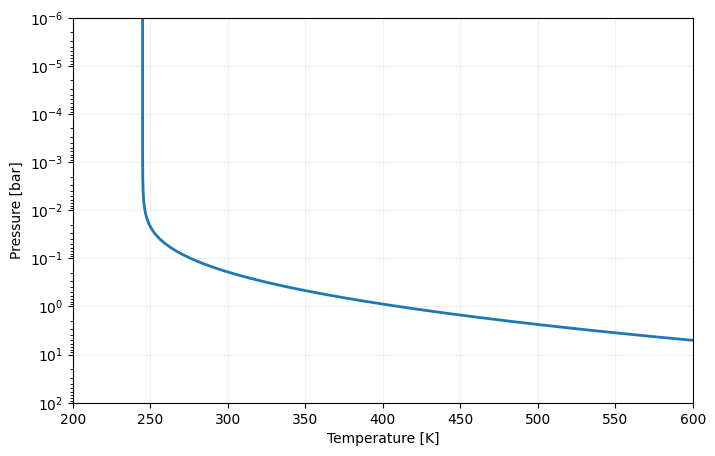

In [5]:
parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= planet.radius),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'T_int': Parameter('T_int', False, value= retrieval.best_fit_parameters['T_int'].value),
    'T_equ': Parameter('T_equ', False, value= retrieval.best_fit_parameters['T_equ'].value),
    'gamma': Parameter('gamma', False, value= retrieval.best_fit_parameters['gamma'].value),
    'log_kappa_IR': Parameter('log_kappa_IR', False, value= retrieval.best_fit_parameters['log_kappa_IR'].value),
    'log_kzz': Parameter('log_kzz', False, value= retrieval.best_fit_parameters['log_kzz'].value),
    'log_X_cb_H2O(l)': Parameter('log_X_cb_H2O(l)', False, value= retrieval.best_fit_parameters['log_X_cb_H2O(l)'].value),
    'sigma_lnorm': Parameter('sigma_lnorm', False, value= retrieval.best_fit_parameters['sigma_lnorm'].value),
    'log_Pbase_H2O(l)': Parameter('log_Pbase_H2O(l)', False, value= retrieval.best_fit_parameters['log_Pbase_H2O(l)'].value),
    'fsed_H2O(l)': Parameter('fsed_H2O(l)', False, retrieval.best_fit_parameters['fsed_H2O(l)'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval.best_fit_parameters['patchiness'].value),
    'CH4': Parameter('CH4', False, value= -1.88),
    'CO2': Parameter('CO2', False, value= -2.0),
}

line_species = [
    'CH4',
    'CO2',
]

for i,j in retrieval.best_fit_parameters.items():
    print(i,j.value)

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = ['H2O(l)']
pressures = np.logspace(-6,2,100)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model= guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(temperature, pressure, linewidth = 2)
ax.set(xlabel="Temperature [K]",
       ylabel="Pressure [bar]",
       xlim=(200, 600),
       ylim=(1e2,1e-6),
       yscale="log",
       # title="T-P profile"
      )
# ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
# ax.text(250, 0.8, "1 bar", fontsize=16, alpha=0.4) 
ax.grid(alpha=0.2)
plt.show()

Not in evaluate mode. Changing run mode to evaluate.

Plotting Best-fit contribution function
Best fit likelihood = 28841.54
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision

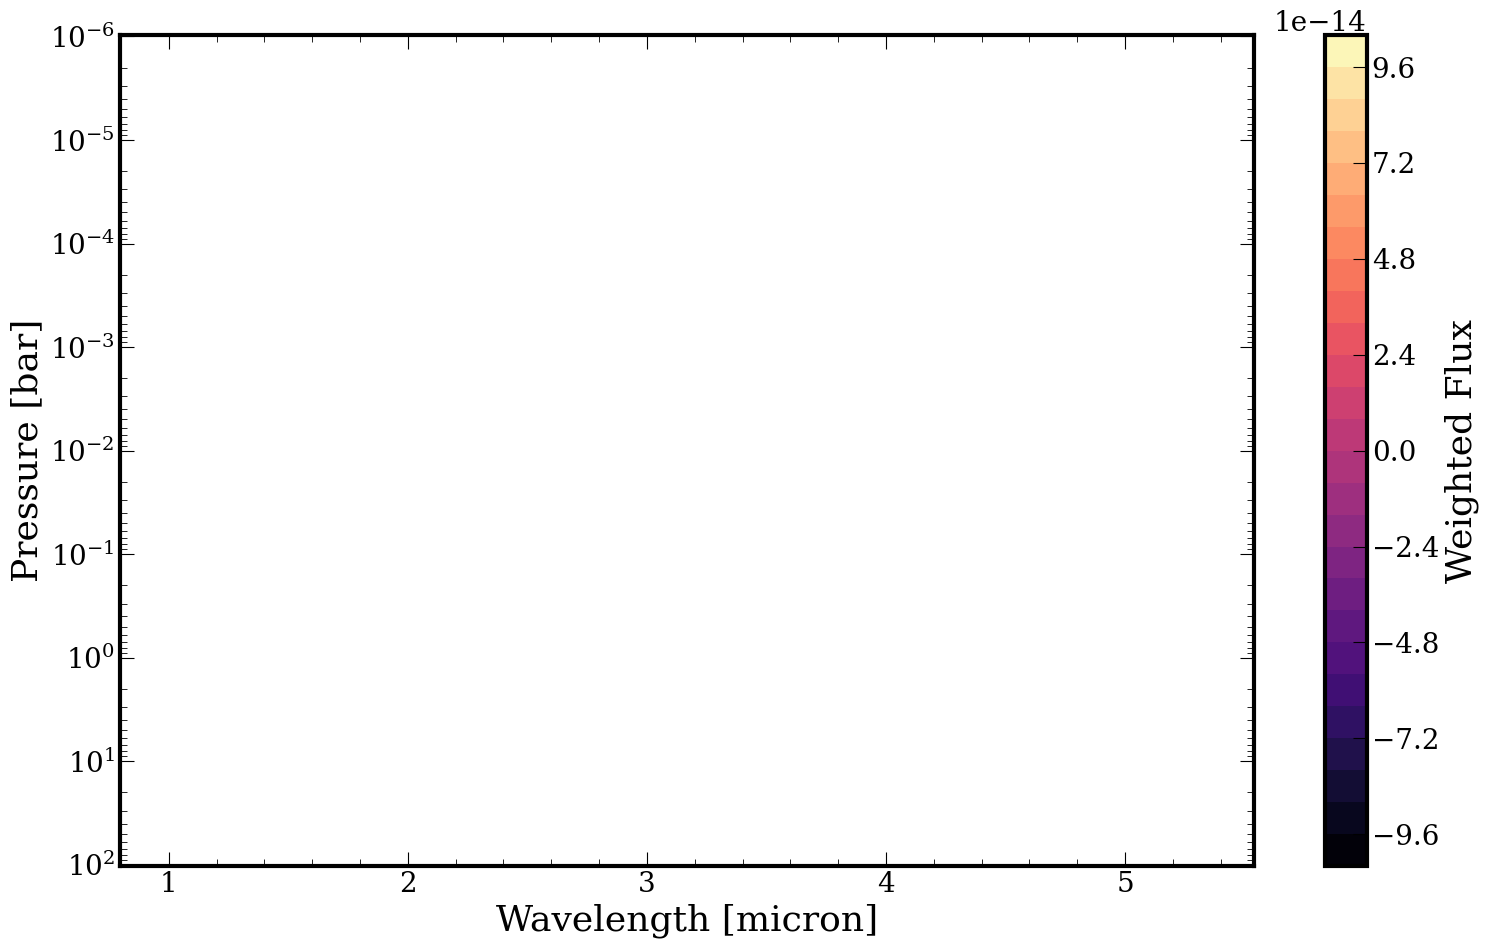

In [9]:
retrieval.plot_contribution(samples_use, parameters_read)
plt.show()

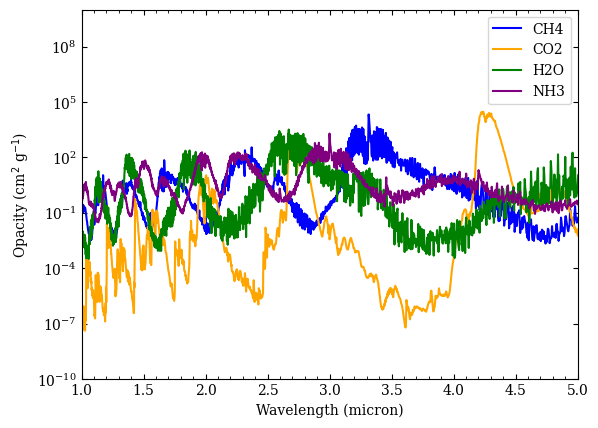

In [12]:
opacities = plot_radtrans_opacities(
    atmosphere,
    atmosphere.line_species,
    temperature=442,
    pressure_bar=1,
    return_opacities=True
)

colors = ['blue', 'orange', 'green', 'purple']
i=0
for species in opacities.keys():
    plt.plot(opacities[species][0], opacities[species][1], label=species,
             color=colors[i]
            )
    i+=1

plt.yscale('log')
plt.xlim([1,5])
plt.ylim([1e-10,1e10])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()
plt.show()

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N

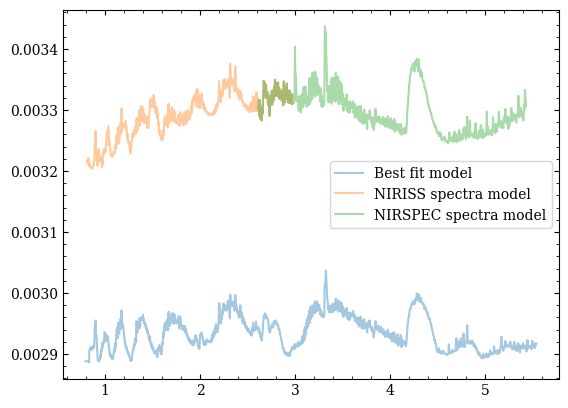

In [13]:
# retrieval.get_reduced_chi2_from_model(wavelength, model, verbose=True, show_chi2=True)

x0, y0 = retrieval.get_best_fit_model(np.array([value for item, value in retrieval.get_best_fit_parameters().items()]), parameters_read)
x1, y1 = retrieval.calculate_forward_model()["K2-18b_NIRISS"]
x2, y2 = retrieval.calculate_forward_model()["K2-18b_NIRSPEC"]
plt.plot(x0, y0, label="Best fit model", alpha=0.4)
plt.plot(x1, y1, label="NIRISS spectra model", alpha=0.4)
plt.plot(x2, y2, label="NIRSPEC spectra model", alpha=0.4)
plt.legend()
plt.show()